In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

C:\Users\cools\AppData\Local\Temp/ipykernel_14488/3397153266.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Store id 
Day of Week 
Date
Customers: the number of customers on a given day.(Target Variable)
Open: an indicator for whether the store was open: 0 = closed, 1 = open.
Promo: indicates whether a store is running a promo on that day.
StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. This has value as "0", "a", "b", "c"
SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.


In [2]:
# importing data
import os

Store50 = pd.read_excel("Store_50.xlsx", parse_dates = True, index_col = 'Date')

In [3]:
Store50.head()

,Store,Day Of Week,Customers,Open,Promotion,State Holiday,School Holiday
Date,,,,,,,
2016-05-31,1044,1,884,1,1,0,0
2016-05-31,1041,1,1032,1,1,0,1
2016-05-31,1036,1,1070,1,1,0,0
2016-05-31,1047,1,2043,1,1,0,0
2016-05-31,1012,1,1239,1,1,0,0


In [4]:
print("The number of rows: ",Store50.shape[0], "\n""The number of columns: ",Store50.shape[1])

The number of rows:  43326 
The number of columns:  7


In [5]:
Store50_1044 = Store50[Store50.Store == 1044]['Customers']. sort_index(ascending=True)

In [6]:
Store50_1044.head()

Date
2014-01-01      0
2014-01-02    473
2014-01-03    483
2014-01-04      0
2014-01-05      0
Name: Customers, dtype: int64

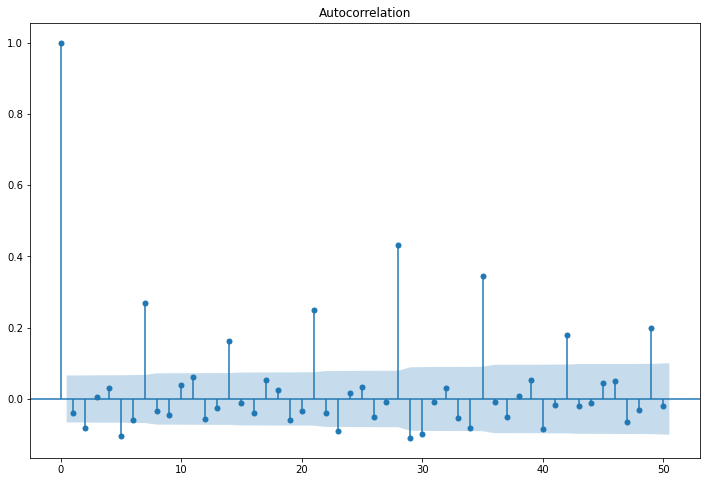

In [7]:
plt.figure(figsize=(12,8))
plot_acf(Store50_1044,lags=50,  ax=plt.gca())
plt.show()

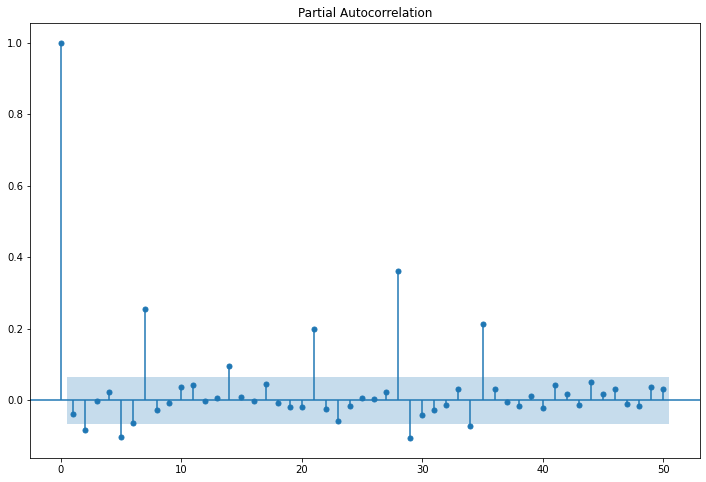

In [8]:
plt.figure(figsize=(12,8))
plot_pacf(Store50_1044, lags=50, ax=plt.gca())
plt.show()

In [9]:
## Seasonality after certain lags is visible. Every 7th day

In [10]:
### Data is being read again for model. This time no index is created while loading the data. First time when the data, index was used
## so that specific Explortory Data Analysis can be done.

In [11]:
Store50 = pd.read_excel("Store_50.xlsx",parse_dates=True)
# Extract customers only for store 1044 and the model would be built for this customer 
Store50_1044 = Store50[Store50.Store == 1044]
# reverse to the order: from 2013 to 2015
Store50_1044 = Store50_1044.sort_index(ascending = False)



In [12]:
Store50_1044.head()

,Store,Day Of Week,Date,Customers,Open,Promotion,State Holiday,School Holiday
43275,1044,2,2014-01-01 00:00:00,0,0,0,a,1
43224,1044,3,2014-02-01 00:00:00,481,1,0,0,1
43173,1044,4,2014-03-01 00:00:00,453,1,0,0,1
43122,1044,5,2014-04-01 00:00:00,497,1,0,0,1
43071,1044,6,2014-05-01 00:00:00,450,1,0,0,0


In [13]:
Store50_1044.rename(columns = {"Day Of Week": "DayOfWeek", "State Holiday":"StateHoliday","School Holiday":"SchoolHoliday"}, 
                      inplace = True) 

In [14]:
Store50_1044['Date'] = pd.to_datetime(Store50_1044['Date'])


In [15]:
Store50_1044['year']= Store50_1044['Date'].dt.year

In [16]:
Store50_1044.head()

,Store,DayOfWeek,Date,Customers,Open,Promotion,StateHoliday,SchoolHoliday,year
43275,1044,2,2014-01-01,0,0,0,a,1,2014
43224,1044,3,2014-02-01,481,1,0,0,1,2014
43173,1044,4,2014-03-01,453,1,0,0,1,2014
43122,1044,5,2014-04-01,497,1,0,0,1,2014
43071,1044,6,2014-05-01,450,1,0,0,0,2014


In [17]:
train=Store50_1044[Store50_1044['year'] !=2016]
test=Store50_1044[Store50_1044['year'] ==2016]

In [18]:
train_mod=train[['Date','Customers']]
test_mod=train[['Date','Customers']]

In [19]:
print(train.shape)
print(test.shape)

(730, 9)
(152, 9)


In [20]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

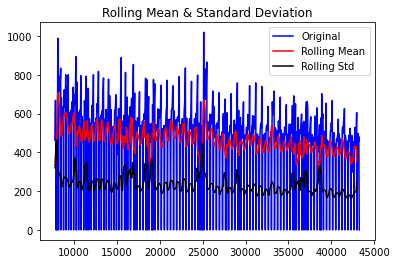

Results of Dickey-Fuller Test:
Test Statistic                  -2.872975
p-value                          0.048582
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64 



In [21]:
test_stationarity(train['Customers'])

In [22]:
## Series is stationary and hence no need for differentiation

In [23]:
import itertools
p = q = range(0, 3)
d= range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 0, 2, 7)
Model: (0, 0, 2)(1, 0, 0, 7)
Model: (0, 0, 2)(1, 0, 1, 7)


In [24]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
print(ARIMA_AIC)


Empty DataFrame
Columns: [param, AIC]
Index: []


In [25]:
train['Customers']

43275      0
43224    481
43173    453
43122    497
43071    450
        ... 
7920     537
7878       0
7836     667
7794     668
7752     462
Name: Customers, Length: 730, dtype: int64

In [26]:
from statsmodels.tsa.arima_model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Customers'],order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:10018.497075995292
ARIMA(0, 0, 1) - AIC:9999.149162156038
ARIMA(0, 0, 2) - AIC:9993.000090066005
ARIMA(1, 0, 0) - AIC:10004.023773703677
ARIMA(1, 0, 1) - AIC:9994.564290496734
ARIMA(1, 0, 2) - AIC:9961.499492485385
ARIMA(2, 0, 0) - AIC:9993.938366710625
ARIMA(2, 0, 1) - AIC:9995.557870420886
ARIMA(2, 0, 2) - AIC:9787.488725139752


In [27]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
8,"(2, 0, 2)",9787.488725
5,"(1, 0, 2)",9961.499492
2,"(0, 0, 2)",9993.000090
6,"(2, 0, 0)",9993.938367
4,"(1, 0, 1)",9994.564290
7,"(2, 0, 1)",9995.557870
1,"(0, 0, 1)",9999.149162
3,"(1, 0, 0)",10004.023774
0,"(0, 0, 0)",10018.497076


In [28]:
## ARIMA(2,0,2) has the lowest AIC
mod = ARIMA(train['Customers'], order=(2,0,2))

results_Arima = mod.fit()

print(results_Arima.summary())

                              ARMA Model Results                              
Dep. Variable:              Customers   No. Observations:                  730
Model:                     ARMA(2, 2)   Log Likelihood               -4887.744
Method:                       css-mle   S.D. of innovations            194.366
Date:                Sat, 01 Jan 2022   AIC                           9787.489
Time:                        16:58:43   BIC                           9815.047
Sample:                             0   HQIC                          9798.121
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             464.3628      7.167     64.791      0.000     450.315     478.410
ar.L1.Customers    -0.4446      0.001   -624.140      0.000      -0.446      -0.443
ar.L2.Customers    -0.9999      

In above results, more the absolute value of z, more significant the term.

In [29]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results_Arima.forecast(steps=152)

In [30]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test.Customers,pred[0],squared=False)
print(rmse)

236.9092565257085


In [31]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(2,0,2)'])

resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257


In [32]:
### As the dataset has seasonality.. Let's build the model with SARIMA

In [33]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMA_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [34]:
SARIMA_AIC

,param,seasonal,AIC


In [35]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Customers'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
        

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:11185.950413292372
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:10518.569230074725
SARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:10040.609277392832
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:9521.374457632435
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:9016.226831861897
SARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:8914.94917659159
SARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:9122.879538850022
SARIMA(0, 0, 0)x(2, 0, 1, 7)7 - AIC:8919.558922751236
SARIMA(0, 0, 0)x(2, 0, 2, 7)7 - AIC:8885.374415308714
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:10844.339587952016
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:10277.4163703857
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:9913.184015362123
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:9508.331991534862
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:8963.90810741658
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:8897.644811576396
SARIMA(0, 0, 1)x(2, 0, 0, 7)7 - AIC:9124.566045237305
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:8893.99819666943
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:8865.997236389641
SARIMA(0, 0, 2)x(0, 0, 0, 7)

In [36]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
17,"(0, 0, 1)","(2, 0, 2, 7)",8865.997236
34,"(1, 0, 0)","(2, 0, 1, 7)",8881.347343
8,"(0, 0, 0)","(2, 0, 2, 7)",8885.374415
32,"(1, 0, 0)","(1, 0, 2, 7)",8885.433032
16,"(0, 0, 1)","(2, 0, 1, 7)",8893.998197


In [37]:
import statsmodels.api as sm

## SARIMA(0, 0, 1)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -4426.999
Date:                                Sat, 01 Jan 2022   AIC                           8865.997
Time:                                        17:01:06   BIC                           8893.423
Sample:                                             0   HQIC                          8876.589
                                                - 730                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0403      0.023      1.753      0.080      -0.005       0.085
ar.

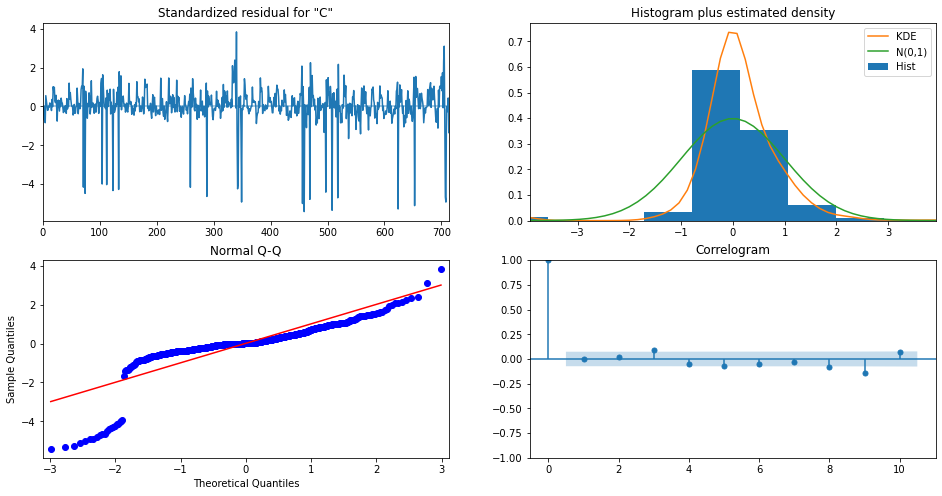

In [38]:
results_SARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

In [39]:
test.head()

,Store,DayOfWeek,Date,Customers,Open,Promotion,StateHoliday,SchoolHoliday,year
7701,1044,4,2016-01-01,0.0,0,0,a,1,2016
7650,1044,5,2016-02-01,633.0,1,0,0,1,2016
7599,1044,6,2016-03-01,530.0,1,0,0,0,2016
7548,1044,7,2016-04-01,0.0,0,0,0,0,2016
7497,1044,1,2016-05-01,845.0,1,1,0,1,2016


In [40]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results_SARIMA.get_forecast(steps=152)
pred.predicted_mean

730    636.530244
731    698.691527
732    616.818327
733     -0.006576
734    730.975724
          ...    
877    599.028593
878    651.584093
879    634.428102
880     -0.006498
881    757.788265
Name: predicted_mean, Length: 152, dtype: float64

In [41]:
pred.summary_frame()

Customers,mean,mean_se,mean_ci_lower,mean_ci_upper
730,636.530244,116.999152,407.216120,865.844368
731,698.691527,117.094020,469.191464,928.191589
732,616.818327,117.094020,387.318265,846.318390
733,-0.006576,117.094020,-229.506639,229.493487
734,730.975724,117.094020,501.475661,960.475786
...,...,...,...,...
877,599.028593,118.512439,366.748481,831.308704
878,651.584093,118.512452,419.303955,883.864231
879,634.428102,118.512452,402.147964,866.708240
880,-0.006498,118.512452,-232.286636,232.273640


In [42]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse)

149.21531509084167


In [43]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(0,0,1)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315


In [44]:
## To get the real forecast for 7 days, we will rerun the model on the complete dataset

mod = sm.tsa.statespace.SARIMAX(Store50_1044['Customers'],
                                order=(0,0,1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              Customers   No. Observations:                  882
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -5408.225
Date:                                Sat, 01 Jan 2022   AIC                          10828.449
Time:                                        17:01:09   BIC                          10857.032
Sample:                                             0   HQIC                         10839.388
                                                - 882                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0211      0.024     -0.890      0.374      -0.068       0.025
ar.

In [45]:
pred = results.get_forecast(steps=7)
pred.predicted_mean

882    666.918917
883    626.019894
884    613.285597
885    639.957345
886    619.066309
887      0.003187
888    658.909210
Name: predicted_mean, dtype: float64

In [46]:
pred.summary_frame()

Customers,mean,mean_se,mean_ci_lower,mean_ci_upper
882,666.918917,124.530137,422.844333,910.993501
883,626.019894,124.557866,381.890962,870.148826
884,613.285597,124.554385,369.163488,857.407707
885,639.957345,124.554385,395.835236,884.079455
886,619.066309,124.554385,374.944200,863.188419
887,0.003187,124.554385,-244.118923,244.125296
888,658.909210,124.554385,414.787101,903.031319


# SARIMAX Models

In [47]:
## This data set has exogeneous variables and hence the same should be considered while creating the model
## so to start with let's create a subset which only has exogeneous variables


In [48]:
ex_train=train[['Open','Promotion','StateHoliday','SchoolHoliday']]
ex_test=test[['Open','Promotion','StateHoliday','SchoolHoliday']]

In [49]:
## State variable has numeric character which has to be convered
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "0"] = 0
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "a"] = 1
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "b"] = 2
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "c"] = 3
ex_train.head()

,Open,Promotion,StateHoliday,SchoolHoliday
43275,0,0,1,1
43224,1,0,0,1
43173,1,0,0,1
43122,1,0,0,1
43071,1,0,0,0


In [50]:
ex_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 43275 to 7752
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           730 non-null    int64 
 1   Promotion      730 non-null    int64 
 2   StateHoliday   730 non-null    object
 3   SchoolHoliday  730 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.5+ KB


In [51]:
ex_train['StateHoliday'] = ex_train['StateHoliday'].astype('int64')
ex_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 43275 to 7752
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           730 non-null    int64
 1   Promotion      730 non-null    int64
 2   StateHoliday   730 non-null    int64
 3   SchoolHoliday  730 non-null    int64
dtypes: int64(4)
memory usage: 28.5 KB


In [52]:
## State variable has numeric character which has to be convered
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "0"] = 0
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "a"] = 1
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "b"] = 2
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "c"] = 3
ex_test.head()

,Open,Promotion,StateHoliday,SchoolHoliday
7701,0,0,1,1
7650,1,0,0,1
7599,1,0,0,0
7548,0,0,0,0
7497,1,1,0,1


In [53]:
ex_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 7701 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           152 non-null    int64 
 1   Promotion      152 non-null    int64 
 2   StateHoliday   152 non-null    object
 3   SchoolHoliday  152 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.9+ KB


In [54]:
ex_test['StateHoliday'] = ex_test['StateHoliday'].astype('int64')
ex_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 7701 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           152 non-null    int64
 1   Promotion      152 non-null    int64
 2   StateHoliday   152 non-null    int64
 3   SchoolHoliday  152 non-null    int64
dtypes: int64(4)
memory usage: 5.9 KB


In [55]:
SARIMAX_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMAX_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [56]:
## Let's first use SARIMAX with exogenous variable 

for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        SARIMAX_AIC = SARIMAX_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)


SARIMA(0, 0, 0)(0, 0, 0, 7) - AIC:8449.698132724228
SARIMA(0, 0, 0)(0, 0, 1, 7) - AIC:8279.98480472933
SARIMA(0, 0, 0)(0, 0, 2, 7) - AIC:8108.890193794648
SARIMA(0, 0, 0)(1, 0, 0, 7) - AIC:8211.177700969916
SARIMA(0, 0, 0)(1, 0, 1, 7) - AIC:7981.851668757995
SARIMA(0, 0, 0)(1, 0, 2, 7) - AIC:7910.419010980676
SARIMA(0, 0, 0)(2, 0, 0, 7) - AIC:8009.100683324965
SARIMA(0, 0, 0)(2, 0, 1, 7) - AIC:7919.601671328055
SARIMA(0, 0, 0)(2, 0, 2, 7) - AIC:7892.637113095068
SARIMA(0, 0, 1)(0, 0, 0, 7) - AIC:8359.036904289142
SARIMA(0, 0, 1)(0, 0, 1, 7) - AIC:8198.54330017995
SARIMA(0, 0, 1)(0, 0, 2, 7) - AIC:8043.613101524841
SARIMA(0, 0, 1)(1, 0, 0, 7) - AIC:8157.241975382818
SARIMA(0, 0, 1)(1, 0, 1, 7) - AIC:7940.376314747527
SARIMA(0, 0, 1)(1, 0, 2, 7) - AIC:7865.163188850631
SARIMA(0, 0, 1)(2, 0, 0, 7) - AIC:7974.072467930224
SARIMA(0, 0, 1)(2, 0, 1, 7) - AIC:7885.556291573992
SARIMA(0, 0, 1)(2, 0, 2, 7) - AIC:7859.525106354978
SARIMA(0, 0, 2)(0, 0, 0, 7) - AIC:8317.247187540732
SARIMA(0, 0, 2

In [57]:
SARIMAX_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
53,"(1, 0, 2)","(2, 0, 2, 7)",7793.802241
50,"(1, 0, 2)","(1, 0, 2, 7)",7795.740951
71,"(2, 0, 1)","(2, 0, 2, 7)",7805.172650
41,"(1, 0, 1)","(1, 0, 2, 7)",7807.882285
44,"(1, 0, 1)","(2, 0, 2, 7)",7808.556010


In [91]:
## SARIMA(1, 0, 2)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -3884.901
Date:                           Sun, 02 Jan 2022   AIC                           7793.802
Time:                                   10:52:05   BIC                           7848.636
Sample:                                        0   HQIC                          7814.981
                                           - 730                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            518.1318     22.455     23.074      0.000     474.121     562.142
Promotion        94.1517      6.96

Looking at the absolute values of z, we see 'Open' is most significant, followed by customer count yesterday(ar.L1), 'Promotion'and forecast error yesterday(ma.L1). 'Open', i.e, whether the store is open or not is the most significant predictor of customer count.

In [59]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730     32.679334
731    588.277050
732    623.648143
733     -8.871379
734    811.741477
          ...    
877    547.418748
878    568.248473
879    601.678628
880     -1.185924
881    762.606920
Name: predicted_mean, Length: 152, dtype: float64

In [60]:
rmse_SARIMAX = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse_SARIMAX)

60.83615497045352


In [61]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_SARIMAX]}
                           ,index=['SARIMAX(1,0,2)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155


In [62]:
## Let's use SARIMAX with exogenous variable whose coefficients are allowed to vary over time 
## Time Varying Linear Model[TVLM] SARIMA(1, 0, 2)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,time_varying_regression=True,mle_regression=False,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -3870.763
Date:                           Sat, 01 Jan 2022   AIC                           7765.527
Time:                                   17:04:43   BIC                           7820.293
Sample:                                        0   HQIC                          7786.685
                                           - 730                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1                 0.6251      0.145      4.297      0.000       0.340       0.910
ma.L1                -

In [63]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730    -86.817515
731    620.882407
732    635.345374
733     -9.924419
734    849.111687
          ...    
877    565.826743
878    605.510473
879    637.386290
880     -0.238909
881    822.104147
Name: predicted_mean, Length: 152, dtype: float64

In [64]:
rmse_SARIMAX_timevarying = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse_SARIMAX_timevarying)

57.75260682641803


In [65]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_SARIMAX_timevarying]}
                           ,index=['SARIMAX_tvlm(1,0,2)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607


In [66]:
ex_1044=Store50_1044[['Open','Promotion','StateHoliday','SchoolHoliday']]

In [67]:
## State variable has numeric character which has to be convered
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "0"] = 0
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "a"] = 1
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "b"] = 2
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "c"] = 3
ex_1044.head()

,Open,Promotion,StateHoliday,SchoolHoliday
43275,0,0,1,1
43224,1,0,0,1
43173,1,0,0,1
43122,1,0,0,1
43071,1,0,0,0


In [68]:
ex_1044.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 43275 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           882 non-null    int64 
 1   Promotion      882 non-null    int64 
 2   StateHoliday   882 non-null    object
 3   SchoolHoliday  882 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 34.5+ KB


In [69]:
ex_1044['StateHoliday'] = ex_1044['StateHoliday'].astype('int64')
ex_1044.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 43275 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           882 non-null    int64
 1   Promotion      882 non-null    int64
 2   StateHoliday   882 non-null    int64
 3   SchoolHoliday  882 non-null    int64
dtypes: int64(4)
memory usage: 34.5 KB


In [70]:
## To get the real forecast for 7 days, we will rerun the model on the complete dataset

mod = sm.tsa.statespace.SARIMAX(Store50_1044['Customers'],exog=ex_1044,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  882
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -4712.961
Date:                           Sat, 01 Jan 2022   AIC                           9449.922
Time:                                   17:04:53   BIC                           9507.075
Sample:                                        0   HQIC                          9471.796
                                           - 882                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            532.4535     19.387     27.465      0.000     494.456     570.450
Promotion        96.4106      5.76

Role of Exogenous variables is not to reduce errors but to ensure to consider the additional variables in a practical way.

Now let's verify if the order as we got it using ACF and PACF gives you a better model in terms of performance.
So we will build two models with order=(0,0,0),seasonal_order=(1, 1,1, 7) and order=(0,0,1),seasonal_order=(1, 1,1, 7) for both 
SARIMAX with and without exogeneous variables
seasonality value for P and Q is assumed to be one because as per ACF and PACF plot seasonality was visible for every 7th period. 
In our SARIMAX loop in the earlier part of code we have assumed d to be 0. With this we will verify if first order differentiation makes a difference 
in terms of value of p and q both for the order and seasonal order.

In [71]:
## SARIMA(0, 0, 0)(1,1,1, 7) 
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Customers   No. Observations:                  730
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -4447.653
Date:                   Sat, 01 Jan 2022   AIC                           8901.305
Time:                           17:04:54   BIC                           8915.022
Sample:                                0   HQIC                          8906.602
                                   - 730                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1793      0.034     -5.256      0.000      -0.246      -0.112
ma.S.L7       -0.8971      0.019    -47.406      0.000      -0.934      -0.860
sigma2      1.464e+04    344

In [72]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results.get_forecast(steps=152)
pred.predicted_mean

730    642.531306
731    665.945207
732    593.709434
733      0.000000
734    746.046269
          ...    
877    544.846190
878    564.700437
879    585.087803
880      0.000000
881    734.028732
Name: predicted_mean, Length: 152, dtype: float64

In [73]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

149.42542301546106


In [74]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMA(0,0,0)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607
"SARIMA(0,0,0)(1,1,1)7",149.425423


In [75]:
## SARIMA(0, 0, 1)(1,1,1, 7) 
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -4440.512
Date:                           Sat, 01 Jan 2022   AIC                           8889.024
Time:                                   17:04:54   BIC                           8907.308
Sample:                                        0   HQIC                          8896.085
                                           - 730                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0574      0.023      2.504      0.012       0.012       0.102
ar.S.L7       -0.1668      0.035     -4.796

In [76]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results.get_forecast(steps=152)
pred.predicted_mean

730    6.272193e+02
731    6.593675e+02
732    5.909295e+02
733   -1.002132e-06
734    7.422851e+02
           ...     
877    5.438530e+02
878    5.651201e+02
879    5.832210e+02
880   -8.588912e-07
881    7.315241e+02
Name: predicted_mean, Length: 152, dtype: float64

In [77]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

148.93879114879144


In [78]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMA(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791


In [79]:
## Exogeneous with order = (0,0,0) and seasonal order (1,1,1,7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(0,0,0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Customers   No. Observations:                  730
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -3947.588
Date:                   Sat, 01 Jan 2022   AIC                           7909.177
Time:                           17:04:57   BIC                           7941.183
Sample:                                0   HQIC                          7921.537
                                   - 730                                         
Covariance Type:                     opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            515.0259     28.154     18.293      0.000     459.844     570.208
Promotion        99.0604      5.136     19.289      0.000      88.995     109.126
StateHoliday    

In [80]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730     34.698809
731    588.237095
732    645.020281
733      0.000000
734    827.240376
          ...    
877    561.220856
878    581.703325
879    634.689436
880      0.000000
881    817.305684
Name: predicted_mean, Length: 152, dtype: float64

In [81]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

67.6976211402273


In [82]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX(0,0,0)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.697621


In [83]:
## Exogeneous with order = (0,0,1) and seasonal order (1,1,1,7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -3923.867
Date:                           Sat, 01 Jan 2022   AIC                           7863.735
Time:                                   17:04:58   BIC                           7900.302
Sample:                                        0   HQIC                          7877.857
                                           - 730                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            547.7981     25.240     21.704      0.000     498.328     597.268
Promotion        90.5093      5.94

In [84]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730   -6.573348e+00
731    5.949634e+02
732    6.421345e+02
733    7.605317e-10
734    8.189086e+02
           ...     
877    5.622416e+02
878    5.879097e+02
879    6.324289e+02
880    6.903222e-10
881    8.080270e+02
Name: predicted_mean, Length: 152, dtype: float64

In [85]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

64.84673555487987


In [86]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.697621
"SARIMAX(0,0,1)(1,1,1)7",64.846736


In [87]:
## Exogeneous with order = (0,0,1) and seasonal order (1,1,1,7) - TVLM
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,time_varying_regression=True,mle_regression=False,
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -2460.091
Date:                           Sat, 01 Jan 2022   AIC                           4936.181
Time:                                   17:05:07   BIC                           4972.704
Sample:                                        0   HQIC                          4950.290
                                           - 730                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1                 1.2780   1.58e-19   8.08e+18      0.000       1.278       1.278
ar.S.L7              -

In [88]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730    2.318612e+01
731    5.056889e+02
732    4.700010e+02
733    3.969326e-12
734    4.940926e+02
           ...     
877    4.609515e+02
878    4.784717e+02
879    4.700010e+02
880    3.423232e-12
881    4.668753e+02
Name: predicted_mean, Length: 152, dtype: float64

In [89]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

197.7154063629036


In [90]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX_tvlm(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.909257
"SARIMA(0,0,1)(2,0,2)7",149.215315
"SARIMAX(1,0,2)(2,0,2)7",60.836155
"SARIMAX_tvlm(1,0,2)(2,0,2)7",57.752607
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.697621
"SARIMAX(0,0,1)(1,1,1)7",64.846736
"SARIMAX_tvlm(0,0,1)(1,1,1)7",197.715406


# END